Develops a custom convolutional neural network (CNN) to classify Alzheimer's disease, focusing on:
- Class weighting to address class imbalance
- Hyperparameter tuning
- Distributed training using TensorFlow's MirroredStrategy
- The effect of class imbalance on class-specific classification accuracy

In [1]:
# "standard"
import numpy as np

# machine learning and statistics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from sklearn.utils.class_weight import compute_class_weight

# misc
from IPython.display import clear_output

# src
import sys, pickle, os
from pathlib import Path
script_dir = Path(os.getcwd()).parent
src_dir = script_dir / 'src'
sys.path.append(str(src_dir))
from visualize import visualize_training, multiclass_summary

clear_output(wait=False)

Create results directory

In [2]:
script_dir = Path(os.getcwd()).parent
results_dir_00 = script_dir / 'results' / 'notebook_00'

results_dir_02 = script_dir / 'results' / 'notebook_02'
os.makedirs(results_dir_02, exist_ok=True)

In [3]:
# Load data file and unpack contents
file_name = results_dir_00 / 'data_preprocessed.pkl'
with open(file_name, 'rb') as f:
    data_preproc = pickle.load(f)

train_data=data_preproc['train_data']
train_lab=data_preproc['train_labels']
test_data=data_preproc['test_data']
test_lab=data_preproc['test_labels']
class_lab = ['Mild', 'Moderate', 'None', 'Very Mild']
    
# Convert labels to categorical
train_lab_cat = to_categorical(train_lab.astype('int8'), num_classes=4)
test_lab_cat = to_categorical(test_lab.astype('int8'), num_classes=4)

Define custom CNN and distributed training strategy

In [4]:
def create_model():
    # three convolutional layers and one fully connected layer
    model = keras.Sequential([
        keras.Input(shape = (128, 128, 1)),

        keras.layers.Conv2D(
            filters=32, 
            kernel_size=(3, 3), 
            activation='relu', 
            kernel_regularizer=keras.regularizers.l2(0.01)),
        keras.layers.MaxPooling2D((2, 2)),

        keras.layers.Conv2D(
            filters=64, 
            kernel_size=(3, 3), 
            activation='relu', 
            kernel_regularizer=keras.regularizers.l2(0.01)),
        keras.layers.MaxPooling2D((2, 2)),
        
        keras.layers.Conv2D(
            filters=128, 
            kernel_size=(3, 3), 
            activation='relu', 
            kernel_regularizer=keras.regularizers.l2(0.01)),
        keras.layers.MaxPooling2D((2, 2)),

        keras.layers.Flatten(),
        keras.layers.Dense(256, activation='relu'), # fully connected layer
        keras.layers.Dense(4, activation='softmax')
    ])
    return model

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = create_model()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

clear_output(wait=False)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,516,484 (24.86 MB)

 Trainable params: 6,516,484 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

Fit model

In [5]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
validation_data = (test_data, test_lab_cat)

history = model.fit(
    train_data, 
    train_lab_cat, 
    epochs=25, 
    batch_size=32, 
    validation_data=validation_data, 
    callbacks=[early_stopping]
)

clear_output(wait=False)

In [6]:
# Save model and history files
model.save(results_dir_02 / 'model_custom_CNN.h5')
print(f"Model saved to {results_dir_02 / 'model_custom_CNN.h5'}")

file_name = results_dir_02 / 'history_custom_CNN.pkl'
with open(file_name, 'wb') as f:
    pickle.dump(history, f)

print(f"Data saved to {file_name}")

Model saved to c:\Users\Bjede\Documents\GitHub\Alzheimers-MRI-Classification\results\notebook_02\model_custom_CNN.h5
Data saved to c:\Users\Bjede\Documents\GitHub\Alzheimers-MRI-Classification\results\notebook_02\history_custom_CNN.pkl


Visualize model fit

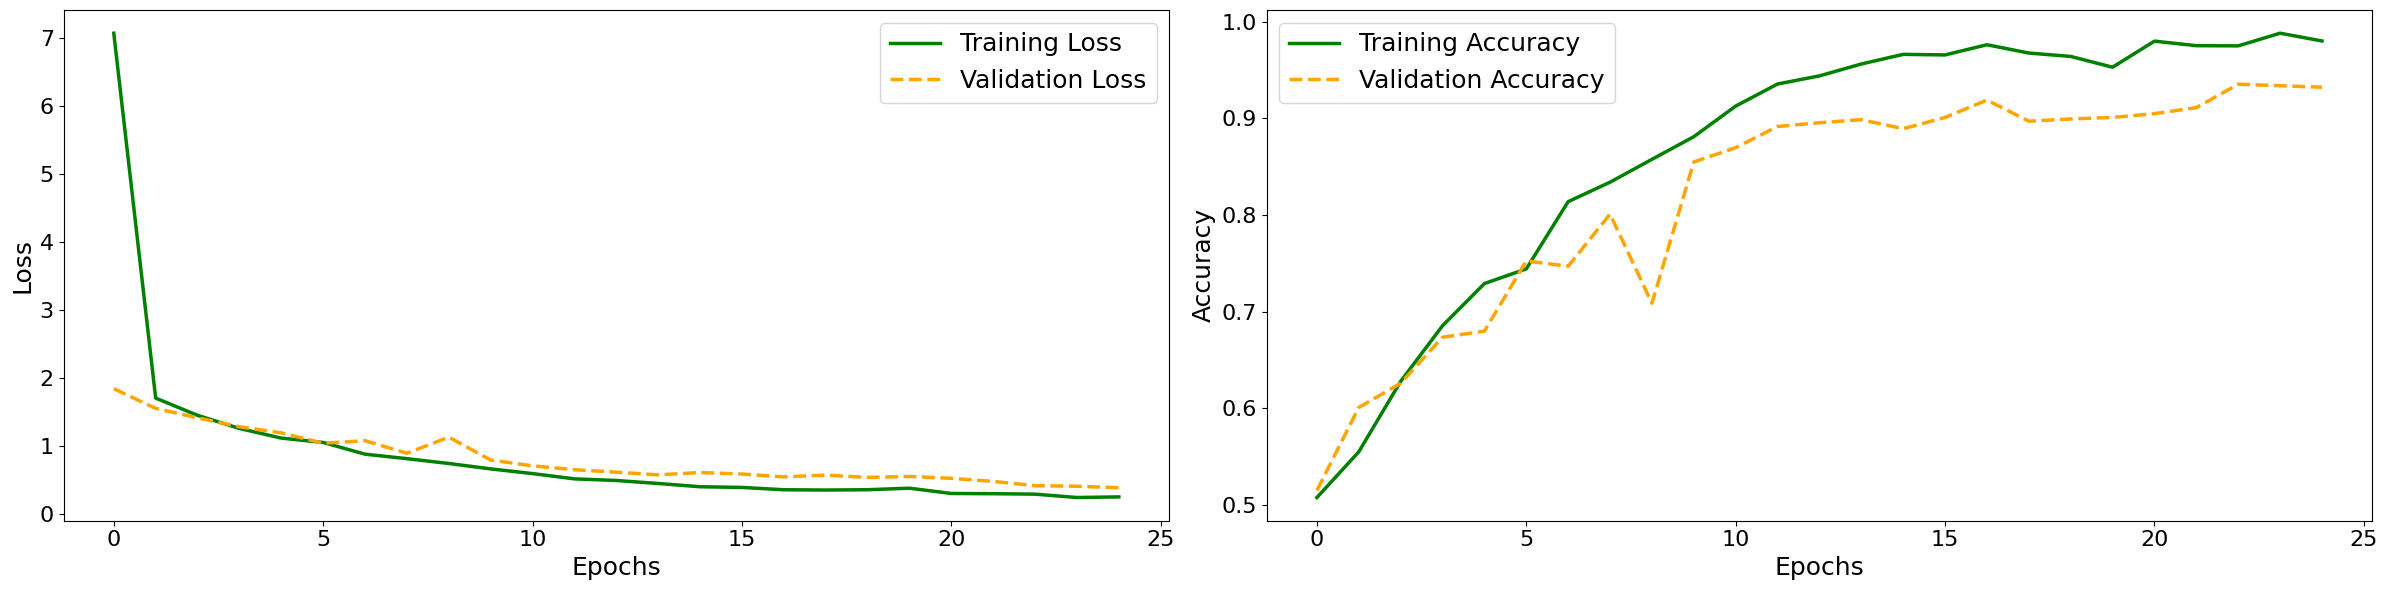

In [7]:
file_name = results_dir_02 / 'history_custom_CNN.pkl'
with open(file_name, 'rb') as f:
    history = pickle.load(f)
clear_output(wait=False)

visualize_training(history)

Predict test data, evaluate accuracy and visualize


Overall classification accuracy is: 93.20 %



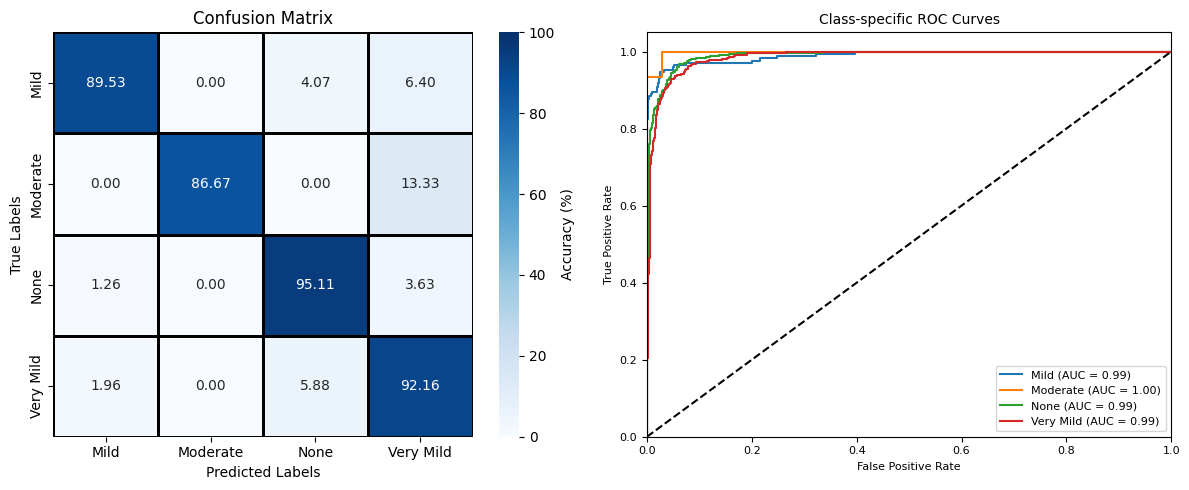

Mild - Precision: 0.90, Recall: 0.90, F1 Score: 0.90
Moderate - Precision: 1.00, Recall: 0.87, F1 Score: 0.93
None - Precision: 0.95, Recall: 0.95, F1 Score: 0.95
Very Mild - Precision: 0.92, Recall: 0.92, F1 Score: 0.92



In [8]:
# Load model
model = load_model(results_dir_02 / 'model_custom_CNN.h5')

# Predict test data
prob = model.predict(test_data)
clear_output(wait=False)
predict_classes = np.argmax(prob, axis=1)
result = predict_classes - test_lab
result_binary = np.argwhere(result == 0)
correct = np.size(result_binary, 0)
acc=correct/test_lab.shape[0] * 100

print()
print(f"Overall classification accuracy is: {acc:.2f} %")
print()

# Visualize summary of predictions
multiclass_summary(prob, test_lab, class_lab)
print()

Overall we do not see here a direct link between the test set class accuracies and the number of measurements in the training set. While the majority class (no AD) exhibited the highest accuracy, the minority class (moderate AD) exhibited the second highest. Regardless, we still have a class imbalance problem that has not been addressed. Next we will compute and train with class weights to account for the imbalance by giving more importance to underrepresented classes during training.

In [10]:
# Use same model architecture from before
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model_weighted = create_model()
    model_weighted.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_lab),
    y=train_lab
)
class_weights_dict = dict(zip(np.unique(train_lab), class_weights))

print(class_weights_dict)

# Train with class weights
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
validation_data = (test_data, test_lab_cat)

history_weighted = model_weighted.fit(
    train_data,
    train_lab_cat,
    epochs=25,
    batch_size=32,
    validation_data=validation_data,
    callbacks=[early_stopping],
    class_weight=class_weights_dict)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


{0: 1.7679558011049723, 1: 26.122448979591837, 2: 0.49883086515978176, 3: 0.7186973610331274}
Epoch 1/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 23s 139ms/step - accuracy: 0.3628 - loss: 23.8483 - val_accuracy: 0.4563 - val_loss: 2.3831
Epoch 2/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - accuracy: 0.3222 - loss: 2.4365 - val_accuracy: 0.4437 - val_loss: 2.1319
Epoch 3/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - accuracy: 0.3674 - loss: 2.0388 - val_accuracy: 0.4672 - val_loss: 1.9556
Epoch 4/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 22s 136ms/step - accuracy: 0.4417 - loss: 1.7514 - val_accuracy: 0.3391 - val_loss: 1.9871
Epoch 5/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step - accuracy: 0.4099 - loss: 1.9654 - val_accuracy: 0.5594 - val_loss: 1.5706
Epoch 6/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 17s 108ms/step - accuracy: 0.5449 - loss: 1.3900 - val_accuracy: 0.5016 - val_loss: 1.6515
Epoch 7/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step - accuracy: 0.5634 - loss: 1.3266 - val_accuracy: 0.4555 - val_l

In [11]:
# Save model and history files
model_weighted.save(results_dir_02 / 'model_custom_CNN_weighted.h5')
print(f"Model saved to {results_dir_02 / 'model_custom_CNN_weighted.h5'}")

file_name = results_dir_02 / 'history_custom_CNN_weighted.pkl'
with open(file_name, 'wb') as f:
    pickle.dump(history_weighted, f)

print(f"Data saved to {file_name}")

Model saved to c:\Users\Bjede\Documents\GitHub\Alzheimers-MRI-Classification\results\notebook_02\model_custom_CNN_weighted.h5
Data saved to c:\Users\Bjede\Documents\GitHub\Alzheimers-MRI-Classification\results\notebook_02\history_custom_CNN_weighted.pkl


Visualize weighted model fit

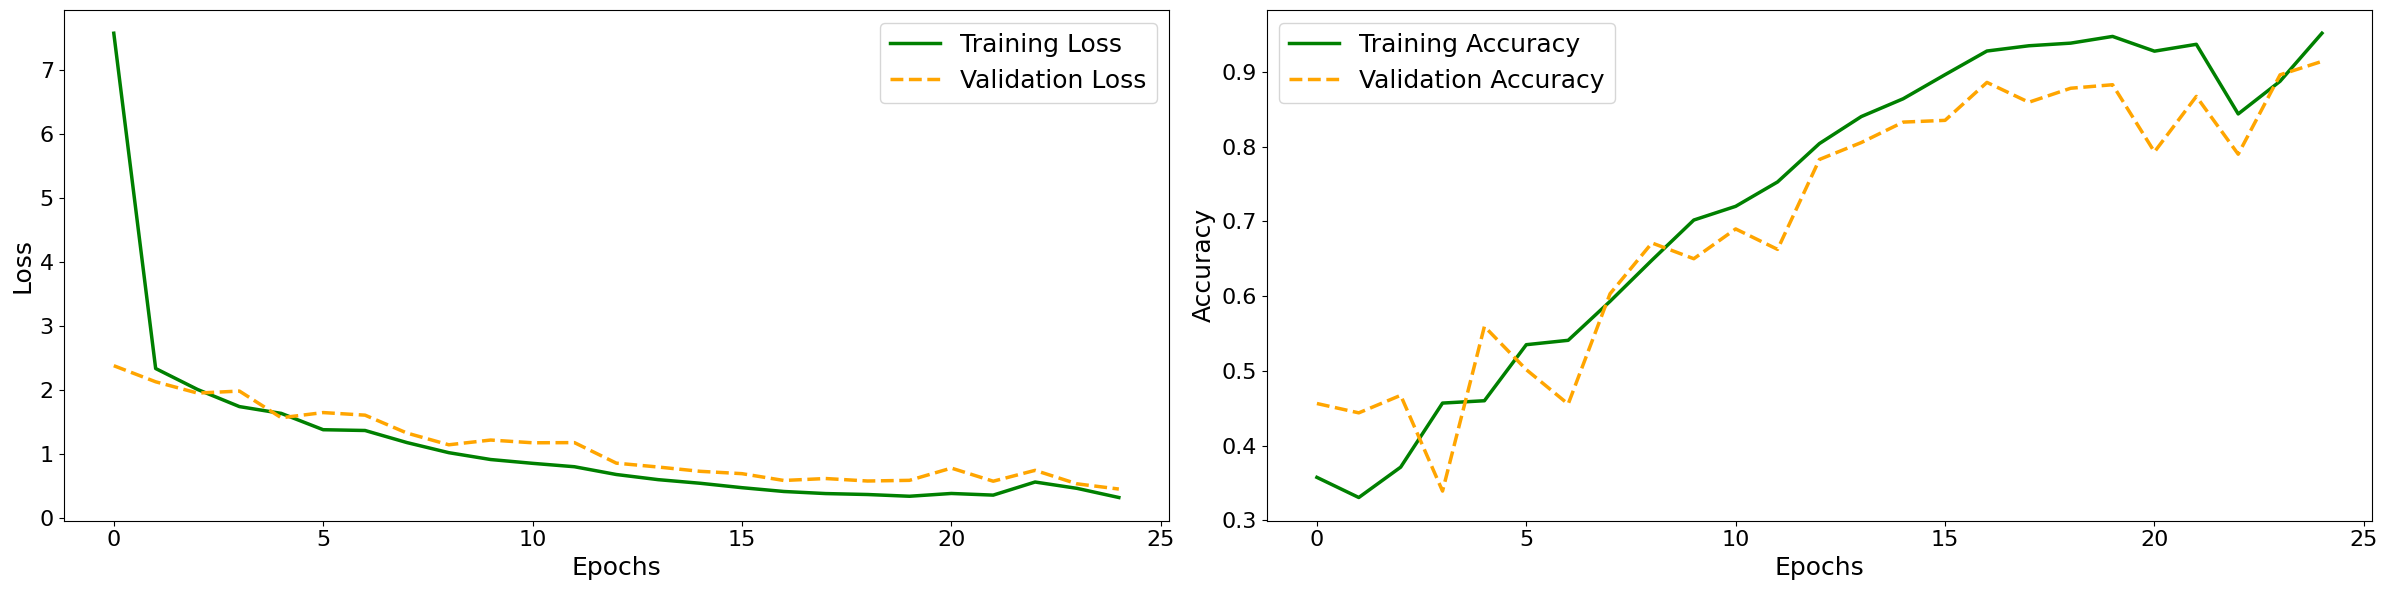

In [12]:
file_name = results_dir_02 / 'history_custom_CNN_weighted.pkl'
with open(file_name, 'rb') as f:
    history_weighted = pickle.load(f)
clear_output(wait=False)

visualize_training(history_weighted)

Predict test data, evaluate accuracy and visualize


Overall classification accuracy is: 91.41 %



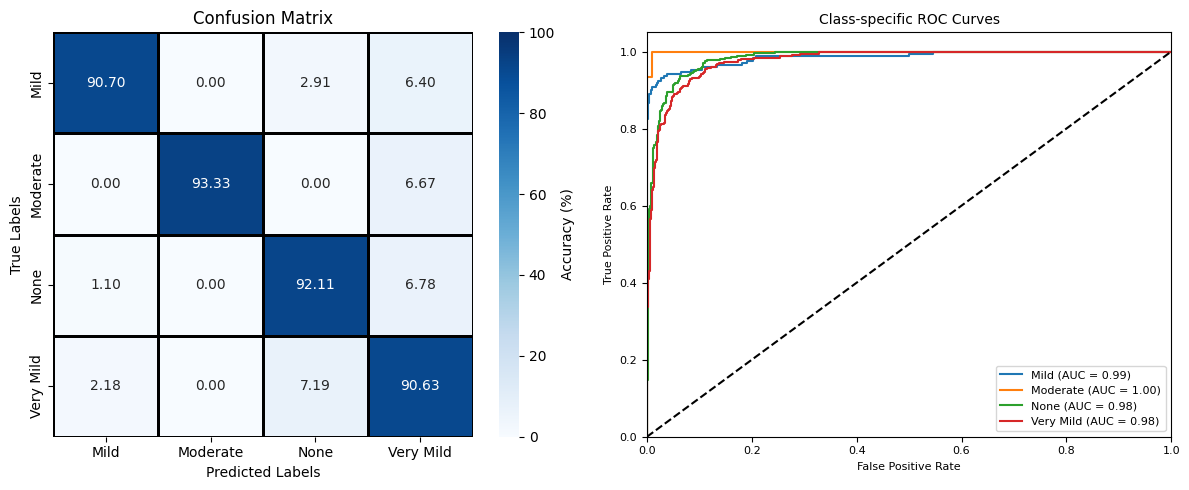

Mild - Precision: 0.90, Recall: 0.91, F1 Score: 0.90
Moderate - Precision: 1.00, Recall: 0.93, F1 Score: 0.97
None - Precision: 0.94, Recall: 0.92, F1 Score: 0.93
Very Mild - Precision: 0.88, Recall: 0.91, F1 Score: 0.89



In [13]:
# Load model
model_weighted = load_model(results_dir_02 / 'model_custom_CNN_weighted.h5')

# Predict test data
prob = model_weighted.predict(test_data)
clear_output(wait=False)
predict_classes = np.argmax(prob, axis=1)
result = predict_classes - test_lab
result_binary = np.argwhere(result == 0)
correct = np.size(result_binary, 0)
acc=correct/test_lab.shape[0] * 100

print()
print(f"Overall classification accuracy is: {acc:.2f} %")
print()

# Visualize summary of predictions
multiclass_summary(prob, test_lab, class_lab)
print()

When using class weighted we actually see a drop in overall accuracy from 93.20% to 91.41%; however, the recall score for the two minority classes as improved, indicating improved balance across all classes. This makes sense as the model is sacrificing a bit of overall accuracy to better handle the underrepresented classes.

In addition to addressing class imbalance via class weighting, the before examples use a custom CNN with default parameters. As was done with the Random Forest classifier, we can tune the parameters of this model to further optimize performance. Here we redefine the CNN exactly as was done before, but now also specify the parameter space associated with different hyperparameters that we want to tune.

In [15]:
# Same architecture as before, but with hyperparameter ranges
def build_model(hp):

    model = keras.Sequential([
    keras.Input(shape = (128, 128, 1)),  
        
    keras.layers.Conv2D(
        filters = hp.Int('conv_1_filter', min_value = 32, max_value = 128, step = 32), 
        kernel_size = hp.Choice('conv_1_kernel', values = [3,3]), 
        activation = 'relu',
        kernel_regularizer=keras.regularizers.l2(0.01)), 
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(
        filters = hp.Int('conv_2_filter', min_value = 64, max_value = 128, step = 32),
        kernel_size = hp.Choice('conv_2_kernel', values = [3,3]),
        activation = 'relu',
        kernel_regularizer=keras.regularizers.l2(0.01)), 
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(
        filters = hp.Int('conv_3_filter', min_value = 96, max_value = 128, step = 32),
        kernel_size = hp.Choice('conv_3_kernel', values = [3,3]),
        activation = 'relu',
        kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.MaxPooling2D((2, 2)),
        
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value = 128, max_value = 256, step = 32),
        activation='relu',
        kernel_regularizer=keras.regularizers.l2(0.01)),
        
    keras.layers.Dropout(0.5),
        
    keras.layers.Dense(4, activation = 'softmax')
    ])
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])
    model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    
    return model

Initiate tuner

In [16]:
script_dir = Path(os.getcwd()).parent
tuner_dir = script_dir / 'results' / 'notebook_02' / 'tuner_dir'
tuner = kt.Hyperband(build_model, objective='val_accuracy', max_epochs=20, factor=3, directory=tuner_dir, project_name='AD_class')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

Run search

In [17]:
# Tune parameters on subset of data to conserve time/memory
subset = []
for label in np.unique(train_lab):
    label_indices = np.where(train_lab == label)[0]
    np.random.shuffle(label_indices)
    subset.extend(label_indices[:int(0.25 * len(label_indices))])
subset = np.array(subset)
train_data_tune = train_data[subset,:,:]
train_lab_tune = train_lab[subset]

# Plot bar graph of label distribution in subset
label_counts = np.bincount(train_lab_tune)
labels = np.arange(len(label_counts))

train_lab_tune_cat = to_categorical(train_lab_tune.astype('int8'))
test_data_tune = test_data
test_lab_tune_cat = to_categorical(test_lab.astype('int8'))

# Compute class weights
class_weights_tune = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_lab_tune),
    y=train_lab_tune
)
class_weights_dict_tune = dict(enumerate(class_weights_tune))

In [18]:
tuner.search(
    train_data_tune,
    train_lab_tune_cat,
    epochs = 10,
    callbacks = [stop_early],
    validation_data = (test_data_tune, test_lab_tune_cat),
    class_weight = class_weights_dict_tune,
)

Trial 30 Complete [00h 10m 36s]
val_accuracy: 0.512499988079071

Best val_accuracy So Far: 0.6781250238418579
Total elapsed time: 02h 55m 02s


Even though this accuracy is lower than expected given the previous results, tuning was performed on a subset of training data and with limited training epochs to conserve time and memory. Nevertheless, training data was randomly sampled and should be representative of the total dataset. Therefore, we will use the best hyperparameters found here for further model training.

In [19]:
# Optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

# Save best hyperparameters
file_name = results_dir_02 / 'best_hps_custom_CNN.pkl'
with open(file_name, 'wb') as f:
    pickle.dump(best_hps, f)

print(f"Data saved to {file_name}")

Data saved to c:\Users\Bjede\Documents\GitHub\Alzheimers-MRI-Classification\results\notebook_02\best_hps_custom_CNN.pkl


In [20]:
file_name = results_dir_02 / 'best_hps_custom_CNN.pkl'
with open(file_name, 'rb') as f:
    best_hps = pickle.load(f)
clear_output(wait=False)

print(f"""
Optimal parameters are as follows:

Filter 1 output dim: {best_hps.get('conv_1_filter')}
Filter 2 output dim: {best_hps.get('conv_2_filter')}
Filter 3 output dim: {best_hps.get('conv_3_filter')}

Dense layer units: {best_hps.get('dense_1_units')}

Learning Rate: {best_hps.get('learning_rate')}
""")


Optimal parameters are as follows:

Filter 1 output dim: 128
Filter 2 output dim: 128
Filter 3 output dim: 96

Dense layer units: 224

Learning Rate: 0.0001



Re-train with full training data and optimal hyperparameters

In [21]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    train_data,
    train_lab_cat,
    epochs = 25,
    callbacks = [stop_early],
    validation_data = (test_data, test_lab_cat),
    class_weight = class_weights_dict
    )

clear_output(wait=False)

In [22]:
# Save model and history files
model.save(results_dir_02 / 'model_custom_CNN_best_hp.h5')
print(f"Model saved to {results_dir_02 / 'model_custom_CNN_best_hp.h5'}")

file_name = results_dir_02 / 'history_custom_CNN_best_hp.pkl'
with open(file_name, 'wb') as f:
    pickle.dump(history, f)

print(f"Data saved to {file_name}")

Model saved to c:\Users\Bjede\Documents\GitHub\Alzheimers-MRI-Classification\results\notebook_02\model_custom_CNN_best_hp.h5
Data saved to c:\Users\Bjede\Documents\GitHub\Alzheimers-MRI-Classification\results\notebook_02\history_custom_CNN_best_hp.pkl


Best epoch: 20


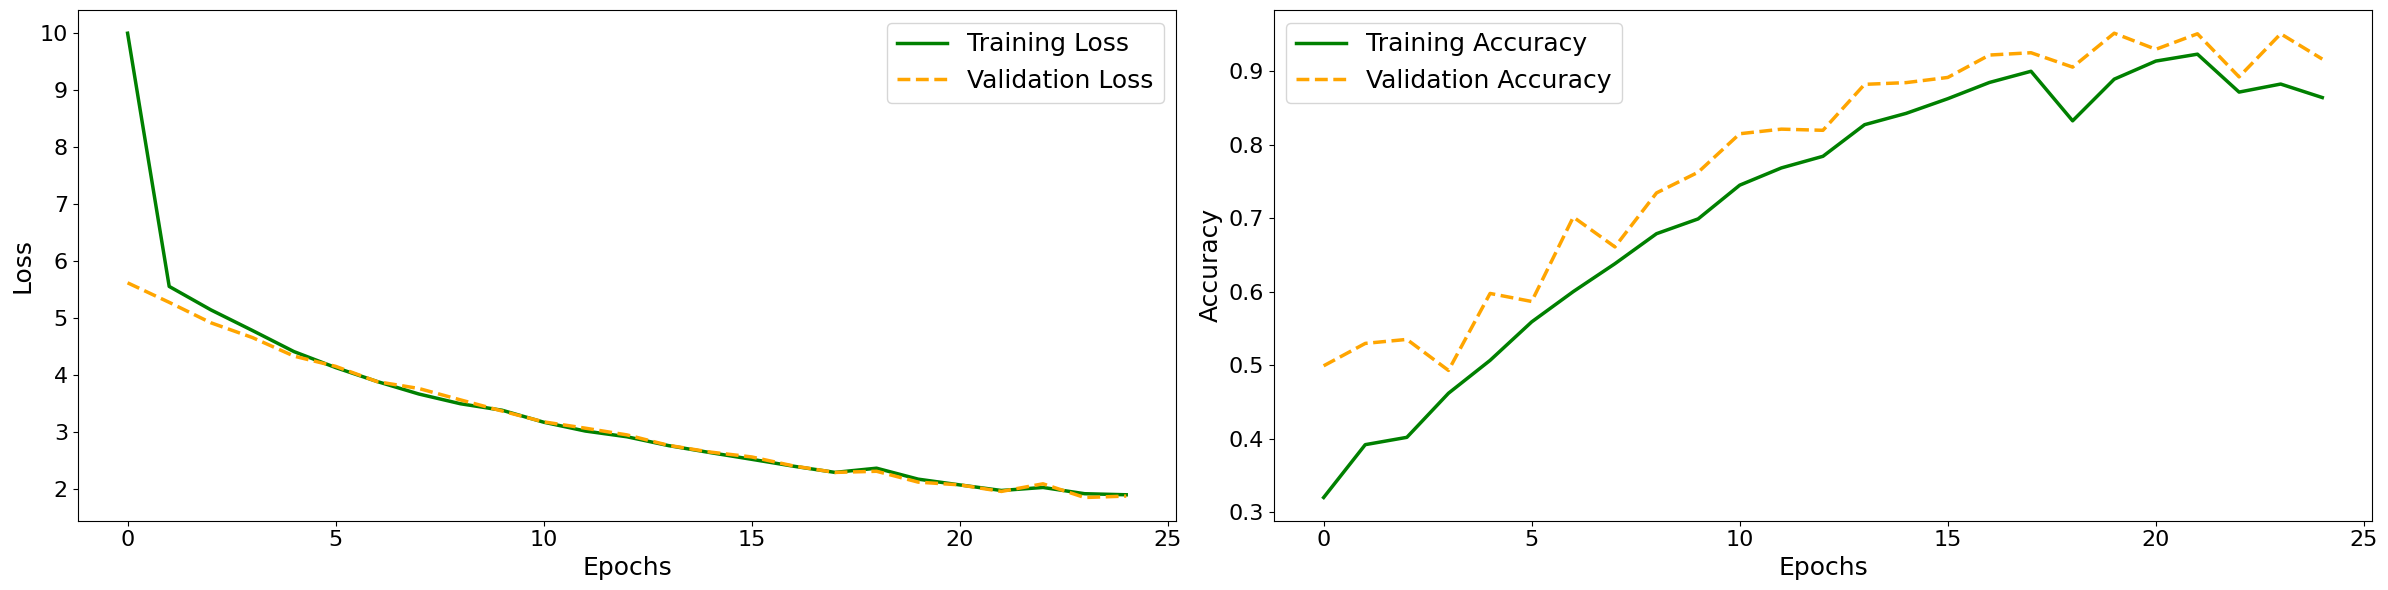

In [23]:
file_name = results_dir_02 / 'history_custom_CNN_best_hp.pkl'
with open(file_name, 'rb') as f:
    history = pickle.load(f)
clear_output(wait=False)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

visualize_training(history)

When compared to the original training strategy, that with optimal hyperparameters clearly maximizes the test accuracy across training. However, lets examine model fit in more detail.


Overall classification accuracy is: 91.64 %



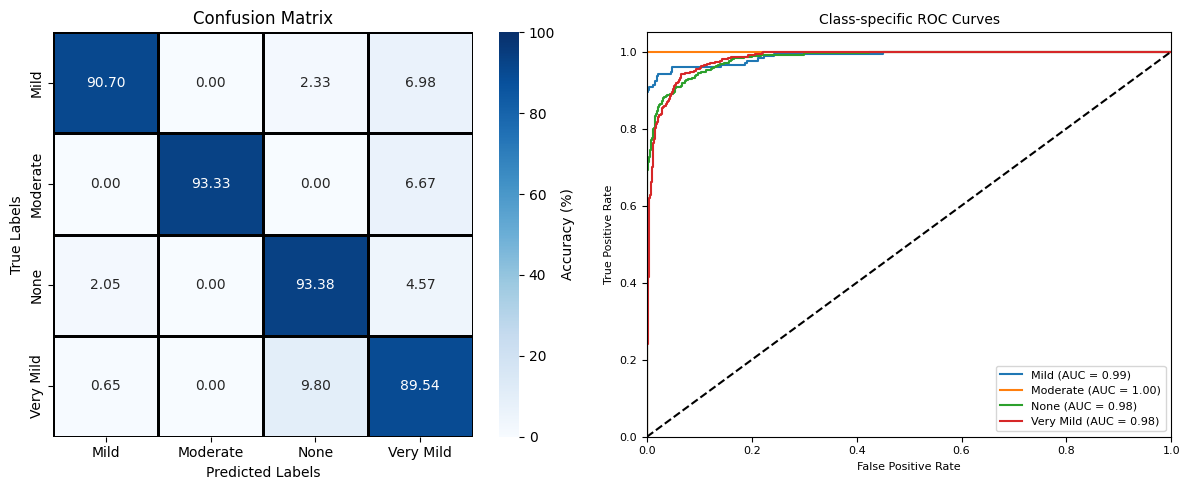

Mild - Precision: 0.91, Recall: 0.91, F1 Score: 0.91
Moderate - Precision: 1.00, Recall: 0.93, F1 Score: 0.97
None - Precision: 0.92, Recall: 0.93, F1 Score: 0.93
Very Mild - Precision: 0.91, Recall: 0.90, F1 Score: 0.90



In [24]:
# Load model
model = load_model(results_dir_02 / 'model_custom_CNN_best_hp.h5')

# Predict test data
prob = model.predict(test_data)
clear_output(wait=False)
predict_classes = np.argmax(prob, axis=1)
result = predict_classes - test_lab
result_binary = np.argwhere(result == 0)
correct = np.size(result_binary, 0)
acc=correct/test_lab.shape[0] * 100

print()
print(f"Overall classification accuracy is: {acc:.2f} %")
print()

# Visualize summary of predictions
multiclass_summary(prob, test_lab, class_lab)
print()

In this case, hyperparameter tuning very slightly improved overall classification accuracy, but we still see a nice balance across classes due to the class weighting. In particular, the moderate AD class, which is by far the minority class in the entire dataset, clearly exhibits a strong accuracy. This is in contrast to the unbalanced and untuned model where the accuracy on this class was the weakest. Overall, while likely not perfect, the optimized CNN in the end performs well across all classes and overall.